Activate conda: `source ~/miniconda3/etc/profile.d/conda.sh`

In [16]:
'''Packages need install
!pip install tensorflow_hub # support CLAREAugmenter
'''

'Packages need install\n!pip install tensorflow_hub # support CLAREAugmenter\n'

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.utils import pad_sequences
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

2023-10-23 02:25:22.646445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
l_dataset = pd.read_csv("L.csv", delimiter=";", encoding="windows-1251")
c_dataset = pd.read_csv("C.csv", delimiter=";", encoding="windows-1251")

# Overview dataset

In [19]:
l_dataset.shape, c_dataset.shape

((50990, 6), (28978, 6))

In [20]:
l_dataset.head()

,Number,Date,UID,Desc,Group,Cat
0,1060141,12.03.2021 11:33,7b5dc3bb-1dcb-4954-9f3c-c5dc9c7d45d2,Не горит лампа в коридоре,Управление домом,"Разбитые стекла, сорванные створки оконных пер..."
1,1112641,2021-05-27 14:16:23.000,8361aa95-b693-444e-a212-8e1da60e8fde,кривой дорожный знак,Дороги,Общие вопросы
2,1112656,31.05.2021 12:07,7ac9fbb2-f72f-471d-9a10-ff191b9be927,Провал колодца на пешеходной дороге,Канализация,Общие вопросы
3,1112657,31.05.2021 12:12,3777d635-b4da-4897-9b89-2ba1aa44d891,Низкие температурные параметры ГВС,ГВС,Общие вопросы
4,1112668,01.06.2021 11:17,badc0911-6201-4a4e-963e-a63a6a3d408c,запах канализации,Канализация,Общие вопросы


In [21]:
c_dataset.head()

,Number,Date,UID,Desc,Group,Cat
0,1346291,01.01.2023 2:10,e87b2cfa-6159-4aa2-b789-3974a01e0b0a,Застряли в лифте,NaN,NaN
1,1346298,01.01.2023 9:09,d6257b7b-d68c-449f-aef3-6c4af1a2d78f,Течь батареи в спальной,NaN,NaN
2,1346301,01.01.2023 10:37,927aeffe-0842-4894-8ada-0a91ccdf1692,Течь сверху по стояку,NaN,NaN
3,1346303,01.01.2023 10:56,9884e4a6-2ce4-485b-913d-8e75c7779302,Течь КНС в 3 подвале,NaN,NaN
4,1346306,01.01.2023 11:44,4593c91a-8b75-46e4-83e5-557d730abea0,Течь кровли (забита ливневка),NaN,NaN


In [22]:
l_dataset.isna().sum()

Number    0
Date      0
UID       0
Desc      2
Group     0
Cat       0
dtype: int64

In [23]:
idx_na = l_dataset[l_dataset["Desc"].isna()].index
idx_na

Index([36, 158], dtype='int64')

In [24]:
# remove nan desc
l_dataset = l_dataset[~l_dataset.index.isin(idx_na)]

In [25]:
l_dataset = l_dataset.reset_index(drop=True)

In [26]:
l_dataset.shape

(50988, 6)

In [27]:
c_dataset.isna().sum()

Number        0
Date          0
UID           0
Desc          0
Group     28978
Cat       28978
dtype: int64

In [28]:
# check balance of data
l_dataset['Group'].value_counts()

Group
Управление домом                 47005
ГВС                               1729
Лифты                             1269
Домофоны                           859
Общие вопросы                       47
Благоустройство                     34
Бродячие животные                   14
Отопление                            5
ХВС                                  4
Электроэнергия                       3
Сантехника                           3
Канализация                          3
Газоснабжение                        2
Дороги                               2
Водоотведение                        2
Ливневки                             1
Вентиляция                           1
Мусоропровод                         1
Уборка  придомовой территории        1
Работа МФЦ                           1
Диспетчеризация                      1
Приборы учета                        1
Name: count, dtype: int64

In [29]:
l_dataset['Cat'].value_counts()

Cat
Сантехника                                                            12401
Отопление (Отсутствие)                                                 5546
Общие вопросы                                                          4617
ГВС (Несоответствие температурных параметров)                          4013
Канализация                                                            3817
                                                                      ...  
Ликвидация воздушных пробок                                               1
Отключение стояков отопления                                              1
Устранение аварии                                                         1
Течи в водопроводных кранах и в кранах сливных бачков при унитазах        1
Подключение к диспетчеризации                                             1
Name: count, Length: 97, dtype: int64

In [30]:
# Count nums of label just have 1
print('1: ', sum(l_dataset['Cat'].value_counts() == 1))
# Count nums of label less than 10
print('<10: ', sum(l_dataset['Cat'].value_counts() < 10))
# Count nums of label less than 100
print('<100: ', sum(l_dataset['Cat'].value_counts() < 100))

1:  12
<10:  35
<100:  64


In [31]:
printf('First part done')

NameError: name 'printf' is not defined

## Data Augmentation by googletrans + textattack
[reference](https://www.kaggle.com/code/tuckerarrants/using-google-translate-for-nlp-augmentation)
<br>
[ref_v1](https://ruslanmv.com/blog/How-to-handle-imbalanced-text-data-in-Natural-Language-Processing)

In [ ]:
from textattack.augmentation import EasyDataAugmenter
from textattack.augmentation import WordNetAugmenter
from textattack.augmentation import EmbeddingAugmenter
from textattack.augmentation import CheckListAugmenter
from textattack.augmentation import CLAREAugmenter

In [ ]:
from deep_translator import GoogleTranslator,   \
                            PonsTranslator,     \
                            LingueeTranslator,  \
                            MyMemoryTranslator, \
                            YandexTranslator # can not register api key
MY_DEEPTRANS_API = '5046fb77012286730dd527cb9f2d8e30'

In [ ]:

LANGUAGES_FULL = {
    'af': 'afrikaans',
    'sq': 'albanian',
    'am': 'amharic',
    'ar': 'arabic',
    'hy': 'armenian',
    'az': 'azerbaijani',
    'eu': 'basque',
    'be': 'belarusian',
    'bn': 'bengali',
    'bs': 'bosnian',
    'bg': 'bulgarian',
    'ca': 'catalan',
    'ceb': 'cebuano',
    'ny': 'chichewa',
    'zh-cn': 'chinese (simplified)',
    'zh-tw': 'chinese (traditional)',
    'co': 'corsican',
    'hr': 'croatian',
    'cs': 'czech',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'eo': 'esperanto',
    'et': 'estonian',
    'tl': 'filipino',
    'fi': 'finnish',
    'fr': 'french',
    'fy': 'frisian',
    'gl': 'galician',
    'ka': 'georgian',
    'de': 'german',
    'el': 'greek',
    'gu': 'gujarati',
    'ht': 'haitian creole',
    'ha': 'hausa',
    'haw': 'hawaiian',
    'iw': 'hebrew',
    'he': 'hebrew',
    'hi': 'hindi',
    'hmn': 'hmong',
    'hu': 'hungarian',
    'is': 'icelandic',
    'ig': 'igbo',
    'id': 'indonesian',
    'ga': 'irish',
    'it': 'italian',
    'ja': 'japanese',
    'jw': 'javanese',
    'kn': 'kannada',
    'kk': 'kazakh',
    'km': 'khmer',
    'ko': 'korean',
    'ku': 'kurdish (kurmanji)',
    'ky': 'kyrgyz',
    'lo': 'lao',
    'la': 'latin',
    'lv': 'latvian',
    'lt': 'lithuanian',
    'lb': 'luxembourgish',
    'mk': 'macedonian',
    'mg': 'malagasy',
    'ms': 'malay',
    'ml': 'malayalam',
    'mt': 'maltese',
    'mi': 'maori',
    'mr': 'marathi',
    'mn': 'mongolian',
    'my': 'myanmar (burmese)',
    'ne': 'nepali',
    'no': 'norwegian',
    'or': 'odia',
    'ps': 'pashto',
    'fa': 'persian',
    'pl': 'polish',
    'pt': 'portuguese',
    'pa': 'punjabi',
    'ro': 'romanian',
    'ru': 'russian',
    'sm': 'samoan',
    'gd': 'scots gaelic',
    'sr': 'serbian',
    'st': 'sesotho',
    'sn': 'shona',
    'sd': 'sindhi',
    'si': 'sinhala',
    'sk': 'slovak',
    'sl': 'slovenian',
    'so': 'somali',
    'es': 'spanish',
    'su': 'sundanese',
    'sw': 'swahili',
    'sv': 'swedish',
    'tg': 'tajik',
    'ta': 'tamil',
    'te': 'telugu',
    'th': 'thai',
    'tr': 'turkish',
    'uk': 'ukrainian',
    'ur': 'urdu',
    'ug': 'uyghur',
    'uz': 'uzbek',
    'vi': 'vietnamese',
    'cy': 'welsh',
    'xh': 'xhosa',
    'yi': 'yiddish',
    'yo': 'yoruba',
    'zu': 'zulu'
}


In [ ]:
LANGUAGES = {
    'mt': 'maltese',
    'en': 'english', 
    'de': 'german', 
    'bg': 'bulgarian', 
    'pl': 'polish', 
    'pt': 'portuguese', 
    'hu': 'hungarian', 
    'ro': 'romanian', 
    'ru': 'russian', 
    'nl': 'dutch', 
    'slovakian': 'slovakian', 
    'el': 'greek', 
    'sl': 'slovenian', 
    'da': 'danish', 
    'it': 'italian', 
    'es': 'spanish', 
    'fi': 'finnish', 
    'chinese': 'chinese', 
    'zh-cn': 'chinese (simplified)',
    'zh-tw': 'chinese (traditional)',
    'fr': 'french', 
    'cs': 'czech', 
    'laotian': 'laotian', 
    'sv': 'swedish', 
    'lv': 'latvian', 
    'et': 'estonian', 
    'ja': 'japanese'
}

In [ ]:
languages = list(LANGUAGES.keys())
# aug_methods = ['easy', 'wordnet', 'embedding', 'checklist']
aug_methods = ['checklist', 'embedding', 'wordnet']
translators = ['google']#, 'pons', 'linguee',
              #'mymemory', 'libre'] # 'yandex'
def rand_trans_utils(huge=False):
    idx_lang = round(np.random.uniform(0, len(languages) - 1))
    idx_aug_method = round(np.random.uniform(0, len(aug_methods) - 1))
    idx_trans = round(np.random.uniform(0, len(translators) - 1))

    # get aug method
    if aug_methods[idx_aug_method] == 'easy':
        rand_aug_method = EasyDataAugmenter()
    elif aug_methods[idx_aug_method] == 'wordnet':
        rand_aug_method = WordNetAugmenter()
    elif aug_methods[idx_aug_method] == 'checklist':
        rand_aug_method = CheckListAugmenter(pct_words_to_swap=0.2, transformations_per_example=3)
    elif aug_methods[idx_aug_method] == 'clare':
        rand_aug_method = CLAREAugmenter()
    else:
        rand_aug_method = EmbeddingAugmenter()
        
    translator = None
    # get translator
    if translators[idx_trans] == 'google':
        translator = GoogleTranslator
    # elif translators[idx_trans] == 'pons' and not huge:
    #     translator = PonsTranslator
    # elif translators[idx_trans] == 'linguee' and not huge:
    #     translator = LingueeTranslator
    # elif translators[idx_trans] == 'mymemory':
    #     translator = MyMemoryTranslator
    else:
        translator = GoogleTranslator
        
    return languages[idx_lang], rand_aug_method, translator, idx_trans
    

In [ ]:
def back_translate(sequence, label, PROB = 1):
    output_sequence = []
    #store original language so we can convert back
    org_lang = 'ru'
    trans_lang = 'en'

    huge = False
    if len(sequence) > 50:
        huge = True
        
    #randomly choose language to translate sequence to
    target_lang, aug_method, translator, idx_trans = rand_trans_utils(huge)
    translated = None
    aug_translated = None
    #translate to english, that is transform language
    try:
        translated = translator(source=LANGUAGES[org_lang], target=LANGUAGES[trans_lang]).translate(sequence)
        # print(aug_method.augment(translated))
        aug_translated = aug_method.augment(translated)
    except:
        print(f'{translators[idx_trans]} no support translate to {LANGUAGES[trans_lang]}')
        pass
        
    if translated:
        for se in aug_translated:
            translated_next = None
            if trans_lang != target_lang:
                try: 
                    translated_next = translator(source=LANGUAGES[trans_lang], target=LANGUAGES[target_lang]).translate(se)
                except:
                    # print(f'{translators[idx_trans]} no support translate to {LANGUAGES[target_lang]}')
                    break
            #translate back to original language
            if translated_next:
                translated_back = None
                try:
                    translated_back = translator(source=LANGUAGES[target_lang], target=LANGUAGES[org_lang]).translate(translated_next)
                except:
                    print(f'Finally, {translators[idx_trans]} no support translate to {LANGUAGES[org_lang]}')
                    pass
                
                #apply with certain probability
                if np.random.uniform(0, 1) <= PROB:
                    output_sequence.append([translated_back] + label)
    else:
        output_sequence = output_sequence
    output_sequence = [list(x) for x in set(tuple(x) for x in output_sequence)]
    return output_sequence


In [ ]:
#check performance
text = l_dataset['Desc'][10] # sample text
group = l_dataset['Group'][10]
cate = l_dataset['Cat'][10]
label = [group, cate]

aug_result = []
while len(aug_result) < 20: # with 20 data more
    output = back_translate(text, label)
    aug_result.extend(output)

In [ ]:
len(aug_result)

In [ ]:
# compare originla text and augmented text
text

In [ ]:
aug_result[:5]

**Applies to Group labels with quantities less than 100**

In [ ]:
l_dataset.head()

In [ ]:
group_labels_less = l_dataset['Group'].value_counts()[l_dataset['Group'].value_counts() <= 100]

In [ ]:
group_labels_less.shape

In [ ]:
group_labels_less

In [ ]:
printf('error')

In [ ]:

for i in range(len(l_dataset)):
    if l_dataset.loc[i, 'Group'] in group_labels_less.index:
        text = l_dataset.loc[i, 'Desc']
        group = l_dataset.loc[i, 'Group']
        cate = l_dataset.loc[i, 'Cat']
        cur_nums = group_labels_less[l_dataset.loc[i, 'Group']]

        label = [group, cate]

        if cur_nums > 10:
            more = 5
        else:
            more = 20
            
        aug_result = []
        while len(aug_result) < more: # with 20 data more
            output = back_translate(text, label)
            aug_result.extend(output)

        # convert to list
        aug_result = list(list(x) for x in aug_result)
        l_dataset = pd.concat([l_dataset, pd.DataFrame(aug_result, columns=['Desc', 'Group', 'Cat'])], ignore_index=True)


In [ ]:
l_dataset.shape

In [ ]:
l_dataset['Group'].value_counts()

In [ ]:
l_dataset['Cat'].value_counts()

**Augmentation for category**

In [ ]:
cat_labels_less = l_dataset['Cat'].value_counts()[l_dataset['Cat'].value_counts() <= 100]
cat_labels_less[:10]

In [ ]:
cat_labels_less[10:30]

In [ ]:
cat_labels_less[30:]

In [ ]:
cat_labels_less.shape

In [ ]:
# with no parallel, it takes more than x hours

for i in range(len(l_dataset)):
    if l_dataset.loc[i, 'Cat'] in cat_labels_less.index:
        text = l_dataset.loc[i, 'Desc']
        group = l_dataset.loc[i, 'Group']
        cate = l_dataset.loc[i, 'Cat']
        cur_nums = cat_labels_less[l_dataset.loc[i, 'Cat']]

        label = [group, cate]

        if cur_nums > 50:
            more = 2
        elif cur_nums >= 10:
            more = 5
        else:
            more = 20
            
        aug_result = []
        while len(aug_result) < more: # with 20 data more
            output = back_translate(text, label)
            aug_result.extend(output)

        # convert to list
        aug_result = list(list(x) for x in aug_result)
        l_dataset = pd.concat([l_dataset, pd.DataFrame(aug_result, columns=['Desc', 'Group', 'Cat'])], ignore_index=True)


In [ ]:
l_dataset['Cat'].value_counts()

In [ ]:
l_dataset['Group'].value_counts()

In [ ]:
l_dataset.shape

In [ ]:
# save to csv file
l_dataset.to_csv('L_augment.csv', index=False)

In [ ]:
printf('stop run!')

## Cleaning data after augmentation

In [2]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [75]:
import seaborn as sns
import re
import string
import imblearn
from imblearn.over_sampling import SMOTE

In [4]:
l_dataset_aug = pd.read_csv("L_augment.csv")
# l_dataset_aug = pd.read_csv("L.csv", delimiter=";", encoding="windows-1251")
# l_dataset_aug.shape

# l_dataset_aug = l_dataset_aug[~l_dataset_aug.index.isin(idx_na)]
# l_dataset_aug = l_dataset_aug.reset_index(drop=True)

In [5]:
l_dataset_aug['Desc and Group'] = l_dataset_aug['Desc'] + '. ' + l_dataset_aug['Group']

In [6]:
l_dataset_aug.head()

,Number,Date,UID,Desc,Group,Cat,Desc and Group
0,1060141.0,12.03.2021 11:33,7b5dc3bb-1dcb-4954-9f3c-c5dc9c7d45d2,Не горит лампа в коридоре,Управление домом,"Разбитые стекла, сорванные створки оконных пер...",Не горит лампа в коридоре. Управление домом
1,1112641.0,2021-05-27 14:16:23.000,8361aa95-b693-444e-a212-8e1da60e8fde,кривой дорожный знак,Дороги,Общие вопросы,кривой дорожный знак. Дороги
2,1112656.0,31.05.2021 12:07,7ac9fbb2-f72f-471d-9a10-ff191b9be927,Провал колодца на пешеходной дороге,Канализация,Общие вопросы,Провал колодца на пешеходной дороге. Канализация
3,1112657.0,31.05.2021 12:12,3777d635-b4da-4897-9b89-2ba1aa44d891,Низкие температурные параметры ГВС,ГВС,Общие вопросы,Низкие температурные параметры ГВС. ГВС
4,1112668.0,01.06.2021 11:17,badc0911-6201-4a4e-963e-a63a6a3d408c,запах канализации,Канализация,Общие вопросы,запах канализации. Канализация


In [7]:
# Remove duplicated rows
l_dataset_aug = l_dataset_aug.drop_duplicates(subset=['Desc', 'Group', 'Cat'], keep='first')
l_dataset_aug.shape

(38732, 7)

In [8]:
l_dataset_aug['Group'].value_counts()

Group
Управление домом                 34316
Лифты                             1346
Домофоны                          1024
ГВС                                550
Общие вопросы                      278
ХВС                                186
Благоустройство                    178
Водоотведение                      165
Сантехника                         111
Бродячие животные                  109
Отопление                          101
Работа МФЦ                          89
Диспетчеризация                     65
Канализация                         42
Электроэнергия                      39
Дороги                              32
Газоснабжение                       27
Ливневки                            20
Приборы учета                       16
Мусоропровод                        14
Уборка  придомовой территории       14
Вентиляция                          10
Name: count, dtype: int64

In [9]:
l_dataset_aug['Cat'].value_counts()

Cat
Сантехника                                                            9387
Общие вопросы                                                         4691
Электроэнергия                                                        2732
Канализация                                                           2496
Отопление (Отсутствие)                                                2337
                                                                      ... 
Произвести механизирован.уборку терр                                    18
Устранение аварии                                                       17
Течи в водопроводных кранах и в кранах сливных бачков при унитазах      16
Подключение к диспетчеризации                                           10
Ликвидация воздушных пробок                                              3
Name: count, Length: 97, dtype: int64

In [10]:
l_dataset_aug.head()

,Number,Date,UID,Desc,Group,Cat,Desc and Group
0,1060141.0,12.03.2021 11:33,7b5dc3bb-1dcb-4954-9f3c-c5dc9c7d45d2,Не горит лампа в коридоре,Управление домом,"Разбитые стекла, сорванные створки оконных пер...",Не горит лампа в коридоре. Управление домом
1,1112641.0,2021-05-27 14:16:23.000,8361aa95-b693-444e-a212-8e1da60e8fde,кривой дорожный знак,Дороги,Общие вопросы,кривой дорожный знак. Дороги
2,1112656.0,31.05.2021 12:07,7ac9fbb2-f72f-471d-9a10-ff191b9be927,Провал колодца на пешеходной дороге,Канализация,Общие вопросы,Провал колодца на пешеходной дороге. Канализация
3,1112657.0,31.05.2021 12:12,3777d635-b4da-4897-9b89-2ba1aa44d891,Низкие температурные параметры ГВС,ГВС,Общие вопросы,Низкие температурные параметры ГВС. ГВС
4,1112668.0,01.06.2021 11:17,badc0911-6201-4a4e-963e-a63a6a3d408c,запах канализации,Канализация,Общие вопросы,запах канализации. Канализация


In [11]:
l_dataset_aug['Length'] = l_dataset_aug['Desc'].apply(lambda x: len(x))

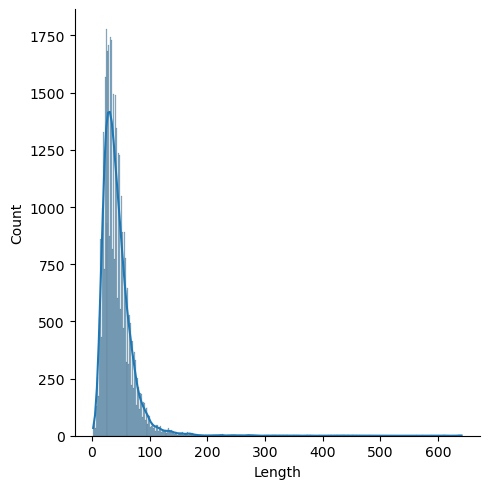

In [12]:
sns.displot(l_dataset_aug['Length'], kde=True)

### Preprocessing

In [13]:
def convert_to_lower(text):
    return text.lower()
    
def remove_numbers(text):
    return re.sub(pattern=r'\d+', repl=" ", string=text)
    
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("russian"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remmove_extra_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def preprocessing_desc():
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc'].apply(lambda x: convert_to_lower(x))
    # l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remove_numbers(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remove_punctuation(x))
    # l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remove_stopwords(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remmove_extra_spaces(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: lemmatizing(x))
    l_dataset_aug['Length after clean'] = l_dataset_aug['Desc clean'].apply(lambda x: len(x))

def preprocessing_desc_and_group():
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc and Group'].apply(lambda x: convert_to_lower(x))
    # l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remove_numbers(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remove_punctuation(x))
    # l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remove_stopwords(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remmove_extra_spaces(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: lemmatizing(x))

In [14]:
# Before preprocessing
l_dataset_aug['Desc'][:5]

0              Не горит лампа в коридоре
1                   кривой дорожный знак
2    Провал колодца на пешеходной дороге
3     Низкие температурные параметры ГВС
4                      запах канализации
Name: Desc, dtype: object

In [15]:
preprocessing_desc_and_group()
l_dataset_aug['Desc Group clean'][:5]

0         не горит лампа в коридоре управление домом
1                        кривой дорожный знак дороги
2    провал колодца на пешеходной дороге канализация
3             низкие температурные параметры гвс гвс
4                      запах канализации канализация
Name: Desc Group clean, dtype: object

In [16]:
preprocessing_desc()
l_dataset_aug['Desc clean'][:5]

0              не горит лампа в коридоре
1                   кривой дорожный знак
2    провал колодца на пешеходной дороге
3     низкие температурные параметры гвс
4                      запах канализации
Name: Desc clean, dtype: object

In [17]:
l_dataset_aug.head()

,Number,Date,UID,Desc,Group,Cat,Desc and Group,Length,Desc Group clean,Desc clean,Length after clean
0,1060141.0,12.03.2021 11:33,7b5dc3bb-1dcb-4954-9f3c-c5dc9c7d45d2,Не горит лампа в коридоре,Управление домом,"Разбитые стекла, сорванные створки оконных пер...",Не горит лампа в коридоре. Управление домом,25,не горит лампа в коридоре управление домом,не горит лампа в коридоре,25
1,1112641.0,2021-05-27 14:16:23.000,8361aa95-b693-444e-a212-8e1da60e8fde,кривой дорожный знак,Дороги,Общие вопросы,кривой дорожный знак. Дороги,20,кривой дорожный знак дороги,кривой дорожный знак,20
2,1112656.0,31.05.2021 12:07,7ac9fbb2-f72f-471d-9a10-ff191b9be927,Провал колодца на пешеходной дороге,Канализация,Общие вопросы,Провал колодца на пешеходной дороге. Канализация,35,провал колодца на пешеходной дороге канализация,провал колодца на пешеходной дороге,35
3,1112657.0,31.05.2021 12:12,3777d635-b4da-4897-9b89-2ba1aa44d891,Низкие температурные параметры ГВС,ГВС,Общие вопросы,Низкие температурные параметры ГВС. ГВС,34,низкие температурные параметры гвс гвс,низкие температурные параметры гвс,34
4,1112668.0,01.06.2021 11:17,badc0911-6201-4a4e-963e-a63a6a3d408c,запах канализации,Канализация,Общие вопросы,запах канализации. Канализация,17,запах канализации канализация,запах канализации,17


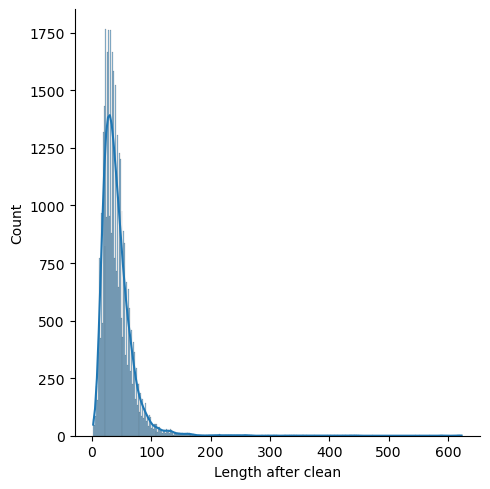

In [18]:
sns.displot(l_dataset_aug['Length after clean'], kde=True)

## Imbalanced Data
https://www.phind.com/agent?cache=clni680eu000hmo079y096gup 
<br>
https://machinelearningmastery.com/one-class-classification-algorithms/
<br>
https://towardsdatascience.com/machine-learning-target-feature-label-imbalance-problem-and-solutions-98c5ae89ad0

In [111]:
y_train_cat_balanced = l_dataset_aug['Cat'].value_counts().loc[lambda x: x >= 50].index
y_train_cat_balanced[:5]

Index(['Сантехника', 'Общие вопросы', 'Электроэнергия', 'Канализация',
       'Отопление (Отсутствие)'],
      dtype='object', name='Cat')

In [112]:
lb_encoding = preprocessing.LabelEncoder()
y_train_cat_balanced_encoded = lb_encoding.fit_transform(y_train_cat_balanced)
y_train_cat_balanced_encoded.shape

(83,)

## Defined multiclass-logloss

In [19]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """
    Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    if len(actual.shape) == 1:
        tmp = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            tmp[i, val] = 1
        actual = tmp

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota
    
    

In [20]:
## Get train data and label
x_train = l_dataset_aug["Desc clean"]
x_train.shape

(38732,)

In [21]:
x_train[:5]

0              не горит лампа в коридоре
1                   кривой дорожный знак
2    провал колодца на пешеходной дороге
3     низкие температурные параметры гвс
4                      запах канализации
Name: Desc clean, dtype: object

In [22]:
## Get train data from desc and group for predict category
x_train_cat_degr = l_dataset_aug["Desc Group clean"]
x_train_cat_degr.shape

(38732,)

In [23]:
y_train_group = l_dataset_aug["Group"] 
y_train_group.shape

(38732,)

In [24]:
y_train_cat = l_dataset_aug["Cat"] 
y_train_cat.shape

(38732,)

In [25]:
# Label encoding for target group
lb_encoding = preprocessing.LabelEncoder()
y_train_group_encoded = lb_encoding.fit_transform(y_train_group)
y_train_group_encoded[:5]

array([19,  8,  9,  4,  9])

In [26]:
# Label encoding for target category
y_train_cat_encoded = lb_encoding.fit_transform(y_train_cat)
y_train_cat_encoded[:5]

array([72, 46, 46, 46, 46])

In [27]:
y_train_group_encoded[:1]

array([19])

In [28]:
x_train.values

array(['не горит лампа в коридоре', 'кривой дорожный знак',
       'провал колодца на пешеходной дороге', ..., 'что ты делаешь',
       'чем закончилось', 'что заканчивается'], dtype=object)

In [76]:
# split train and valid data for group
x_train_group, x_valid_group, y_train_group, y_valid_group = train_test_split(x_train.values, y_train_group_encoded,
                                                                  stratify=y_train_group_encoded,
                                                                  random_state=42,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [77]:
x_train_cat, x_valid_cat, y_train_cat, y_valid_cat = train_test_split(x_train.values, y_train_cat_encoded,
                                                                  stratify=y_train_cat_encoded,
                                                                  random_state=42,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [78]:
x_train_cat_new, x_valid_cat_new, y_train_cat_new, y_valid_cat_new = train_test_split(x_train_cat_degr.values, y_train_cat_encoded,
                                                                  stratify=y_train_cat_encoded,
                                                                  random_state=42,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [79]:
x_train_group.shape, x_valid_group.shape

((30985,), (7747,))

In [80]:
x_train_cat.shape, x_valid_cat.shape, x_train_cat_new.shape

((30985,), (7747,), (30985,))

In [42]:
printf('Error')

NameError: name 'printf' is not defined

## Building Basic Models
[ref](https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle)

### Sub test implementing text with vectorization

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_wb = TfidfVectorizer()
x_train_tfv_wb = tf_wb.fit_transform(x_train)
x_train_tfv_wb = x_train_tfv_wb.toarray()

In [44]:
x_train_tfv_wb, x_valid_tfv_wb, y_train_tfv_wb, y_valid_tfv_wb = train_test_split(x_train_tfv_wb, y_train_group_encoded, test_size=0.2)

In [ ]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(x_train_tfv_wb, y_train_tfv_wb)


In [ ]:
NB_pred = NB.predict(x_valid_tfv_wb)
print(accuracy_score(y_valid_tfv_wb, NB_pred)) # last 0.88

In [ ]:
# printf('Error')

### Model for OverSample

In [ ]:
# RandomOverSampler
# from imblearn.over_sampling import SMOTE
# from collections import Counter

In [ ]:
# Counter(y_train_group)

In [ ]:
# smote = SMOTE()
# x_train_pos, y_train_pos = smote.fit_resample(x_tf, y_train_group)

### First model is a simple TF-IDF (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression

In [81]:
# 
tfv = TfidfVectorizer(min_df=3, max_features=None,
                          strip_accents='unicode',
                          analyzer='word',
                          token_pattern=r'\w{1,}',
                          ngram_range=(1, 3),
                          use_idf=1,
                          smooth_idf=1,
                          sublinear_tf=1) ## add stop words

# Fitting TF-IDF
tfv.fit(list(x_train))
x_train_group_tfv = tfv.transform(x_train_group)
x_valid_group_tfv = tfv.transform(x_valid_group)

x_train_cat_tfv = tfv.transform(x_train_cat)
x_valid_cat_tfv = tfv.transform(x_valid_cat)

x_train_cat_new_tfv = tfv.transform(x_train_cat_new)
x_valid_cat_new_tfv = tfv.transform(x_valid_cat_new)

/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [82]:
# Fitting a simple Logistic Regression for TF-IDF
# model for group
print('Fitting TF-TDF with group label ...')
clf_tfv_group = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_group.fit(x_train_group_tfv, y_train_group)
print('Done.')
print('-' * 50)
# model for cat
print('Fitting TF-TDF with category label ...')
clf_tfv_cat = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_cat.fit(x_train_cat_tfv, y_train_cat)
print('Done.')
print('-' * 50)
# model for cat new
print('Fitting TF-TDF with category label with new data ...')
clf_tfv_cat_new = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_cat_new.fit(x_train_cat_new_tfv, y_train_cat)
print('Done.')

Fitting TF-TDF with group label ...
Done.
--------------------------------------------------
Fitting TF-TDF with category label ...
Done.
--------------------------------------------------
Fitting TF-TDF with category label with new data ...
Done.


**Predict for group**

In [83]:
predicted_group = clf_tfv_group.predict_proba(x_valid_group_tfv)

In [84]:
classify_group = [np.argmax(x) for x in predicted_group]

In [85]:
print("log loss for group: %0.3f" % multiclass_logloss(y_valid_group, predicted_group)) # last: 0.046
print("accuracy for group: %0.3f" % accuracy_score(classify_group, y_valid_group)) # last 0.949

log loss for group: 0.177
accuracy for group: 0.949


**Predict for category**

In [86]:
predicted_cat = clf_tfv_cat.predict_proba(x_valid_cat_tfv)

In [87]:
classify_cat = [np.argmax(x) for x in predicted_cat]

In [88]:
print("log loss for category: %0.3f" % multiclass_logloss(y_valid_cat, predicted_cat)) # last: 0.677
print("accuracy for category: %0.3f" % accuracy_score(y_valid_cat, classify_cat))

log loss for category: 1.285
accuracy for category: 0.676


**Predict for category new**

In [89]:
predicted_cat_new = clf_tfv_cat_new.predict_proba(x_valid_cat_new_tfv)

In [90]:
classify_cat_new = [np.argmax(x) for x in predicted_cat_new]

In [91]:
print("log loss for category: %0.3f" % multiclass_logloss(y_valid_cat, predicted_cat_new)) # last: 0.686
print("accuracy for category: %0.3f" % accuracy_score(y_valid_cat, classify_cat_new))

log loss for category: 1.203
accuracy for category: 0.686


**If using SMOTE for handle imbalanced data**

In [93]:
oversample = SMOTE()
x_train_balanced_group_tfv, y_balaned_group_tfv = oversample.fit_resample(x_train_group_tfv, y_train_group)
oversample_cat_new = SMOTE(k_neighbors=1)
x_train_balanced_cat_new_tfv, y_balaned_cat_new_tfv = oversample_cat_new.fit_resample(x_train_cat_new_tfv, y_train_cat)

In [94]:
# model for group new after balanced
print('Fitting TF-TDF with group label ...')
clf_tfv_group_balanced = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_group_balanced.fit(x_train_balanced_group_tfv, y_balaned_group_tfv)
print('Done.')
print('-' * 50)
# model for cat new after balanced
print('Fitting TF-TDF with category label with new data ...')
clf_tfv_cat_new_balanced = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_cat_new_balanced.fit(x_train_balanced_cat_new_tfv, y_balaned_cat_new_tfv)
print('Done.')

Fitting TF-TDF with group label ...
Done.
--------------------------------------------------
Fitting TF-TDF with category label with new data ...
Done.


In [95]:
predicted_group = clf_tfv_group_balanced.predict_proba(x_valid_group_tfv)
classify_group = [np.argmax(x) for x in predicted_group]

In [96]:
print("log loss for group: %0.3f" % multiclass_logloss(y_valid_group, predicted_group)) # last: 0.046
print("accuracy for group: %0.3f" % accuracy_score(classify_group, y_valid_group)) # last 0.949

log loss for group: 0.275
accuracy for group: 0.937


In [97]:
# predict for category new

In [98]:
predicted_cat_new = clf_tfv_cat_new_balanced.predict_proba(x_valid_cat_new_tfv)
classify_cat_new = [np.argmax(x) for x in predicted_cat_new]

In [99]:
print("log loss for category: %0.3f" % multiclass_logloss(y_valid_cat, predicted_cat_new)) # last: 0.686
print("accuracy for category: %0.3f" % accuracy_score(y_valid_cat, classify_cat_new))

log loss for category: 1.126
accuracy for category: 0.658


### Using CountVectorizer from scikit-learn

In [65]:
ctv = CountVectorizer(analyzer='word',
                         token_pattern=r'\w{1,}',
                         ngram_range=(1, 3),
                         # stop_words = 'russian'
                     )
# Fitting CountVectorizer
ctv.fit(list(x_train))
x_train_group_ctv = ctv.transform(x_train_group)
x_valid_group_ctv = ctv.transform(x_valid_group)

x_train_cat_ctv = ctv.transform(x_train_cat)
x_valid_cat_ctv = ctv.transform(x_valid_cat)

x_train_cat_new_ctv = ctv.transform(x_train_cat_new)
x_valid_cat_new_ctv = ctv.transform(x_valid_cat_new)

In [141]:
# Fitting a simple Logistic Regression for Count Vetorizer
# model for group
print('Fitting CountVectorizer with group label ...')
clf_ctv_group = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_group.fit(x_train_group_ctv, y_train_group)
print('Done.')
print('-' * 50)

Fitting CountVectorizer with group label ...
Done.
--------------------------------------------------


In [142]:
# model for cat - kernel error (maybe hardware limitations)
print('Fitting CountVectorizer with cat label ...')
clf_ctv_cat = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_cat.fit(x_train_cat_ctv, y_train_cat)
print('Done.')
print('-' * 50)
print('Fitting CountVectorizer with cat label with new data...')
clf_ctv_cat_new = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_cat_new.fit(x_train_cat_new_ctv, y_train_cat)
print('Done.')

Fitting CountVectorizer with cat label ...
Done.
--------------------------------------------------
Fitting CountVectorizer with cat label with new data...
Done.


**Predict for group**

In [143]:
predicted_ctv_group = clf_ctv_group.predict_proba(x_valid_group_ctv)

In [144]:
classify_group = [np.argmax(x) for x in predicted_ctv_group]

In [145]:
print("log loss: %0.3f" % multiclass_logloss(y_valid_group, predicted_ctv_group))
print("accuracy for group: %0.3f" % accuracy_score(classify_group, y_valid_group)) # last 0.961

log loss: 0.123
accuracy for group: 0.961


**Predict for category**

In [146]:
predicted_ctv_cat = clf_ctv_cat.predict_proba(x_valid_cat_ctv)

In [147]:
classify_cat = [np.argmax(x) for x in predicted_ctv_cat]

In [148]:
print("log loss: %0.3f" % multiclass_logloss(y_valid_cat, predicted_ctv_cat))
print("accuracy for category: %0.3f" % accuracy_score(classify_cat, y_valid_cat)) # last 0.704

log loss: 0.995
accuracy for category: 0.704


**Predict for category with new data**

In [149]:
predicted_ctv_cat_new = clf_ctv_cat_new.predict_proba(x_valid_cat_new_ctv)

In [150]:
classify_cat_new = [np.argmax(x) for x in predicted_ctv_cat_new]

In [151]:
print("log loss: %0.3f" % multiclass_logloss(y_valid_cat, predicted_ctv_cat_new))
print("accuracy for category: %0.3f" % accuracy_score(classify_cat_new, y_valid_cat)) #last 0.722

log loss: 0.920
accuracy for category: 0.722


In [ ]:
# pritnf('Seconds model done')

In [100]:
# Using SMOTE
oversample = SMOTE()
x_train_balanced_group_ctv, y_balaned_group_ctv = oversample.fit_resample(x_train_group_ctv, y_train_group)
oversample_cat_new = SMOTE(k_neighbors=1)
x_train_balanced_cat_new_ctv, y_balaned_cat_new_ctv = oversample_cat_new.fit_resample(x_train_cat_new_ctv, y_train_cat)

In [107]:
y_train_cat.shape

(30985,)

In [115]:
# Fitting a simple Logistic Regression for Count Vetorizer
# model for group
print('Fitting CountVectorizer with group label ...')
clf_ctv_group_balanced = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_group_balanced.fit(x_train_balanced_group_ctv, y_balaned_group_ctv)
print('Done.')
print('-' * 50)
print('Fitting CountVectorizer with cat label with new data...')
clf_ctv_cat_new_balanced = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_cat_new_balanced.fit(x_train_balanced_cat_new_ctv, y_balaned_cat_new_ctv)
print('Done.')

Fitting CountVectorizer with group label ...
Done.
--------------------------------------------------
Fitting CountVectorizer with cat label with new data...
Done.


In [116]:
predicted_group = clf_ctv_group_balanced.predict_proba(x_valid_group_ctv)
classify_group = [np.argmax(x) for x in predicted_group]

In [117]:
print("log loss for group: %0.3f" % multiclass_logloss(y_valid_group, predicted_group)) # last: 0.046
print("accuracy for group: %0.3f" % accuracy_score(classify_group, y_valid_group)) # last 0.949

log loss for group: 0.286
accuracy for group: 0.921


In [118]:
predicted_cat_new = clf_ctv_cat_new_balanced.predict_proba(x_valid_cat_new_ctv)
classify_cat_new = [np.argmax(x) for x in predicted_cat_new]

In [119]:
print("log loss for category: %0.3f" % multiclass_logloss(y_valid_cat, predicted_cat_new)) # last: 0.686
print("accuracy for category: %0.3f" % accuracy_score(y_valid_cat, classify_cat_new))

log loss for category: 1.420
accuracy for category: 0.634


### Naive Bayes on TF-IDF

In [152]:
# fit from desc
x_naive_tf = tfv.fit_transform(list(x_train))
# fit from desc and group to predict cat
x_naive_new_tf = tfv.fit_transform(list(x_train_cat_degr))

/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [153]:
x_naive_tf.shape, x_naive_new_tf.shape

((38732, 27989), (38732, 32942))

In [154]:
x_train_group_nb_tf, x_valid_group_nb_tf, y_train_group_nb_tf, y_valid_group_nb_tf = train_test_split(x_naive_tf, y_train_group_encoded, test_size=0.2)
x_train_cat_nb_tf, x_valid_cat_nb_tf, y_train_cat_nb_tf, y_valid_cat_nb_tf = train_test_split(x_naive_tf, y_train_cat_encoded, test_size=0.2)
x_train_cat_new_nb_tf, x_valid_cat_new_nb_tf, y_train_cat_new_nb_tf, y_valid_cat_new_nb_tf = train_test_split(x_naive_new_tf, y_train_cat_encoded, test_size=0.2)

In [155]:
# NB for group
clf_nb_tfv_group = MultinomialNB()
clf_nb_tfv_group.fit(x_train_group_nb_tf, y_train_group_nb_tf)

MultinomialNB()

In [156]:
predicted_nb_tfv_group = clf_nb_tfv_group.predict_proba(x_valid_group_nb_tf)

In [157]:
classify_nb_group = [np.argmax(x) for x in predicted_nb_tfv_group]

In [158]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group_nb_tf, predicted_nb_tfv_group))
print("accuracy for group: %0.3f" % accuracy_score(y_valid_group_nb_tf, classify_nb_group)) last: 0.943

log loss: 0.227 
accuracy for group: 0.943


In [159]:
# NB for cat
clf_nb_tfv_cat = MultinomialNB()
clf_nb_tfv_cat.fit(x_train_cat_nb_tf, y_train_cat_nb_tf)

MultinomialNB()

In [160]:
predicted_nb_tfv_cat = clf_nb_tfv_cat.predict_proba(x_valid_cat_nb_tf)

In [161]:
classify_nb_cat = [np.argmax(x) for x in predicted_nb_tfv_cat]

In [162]:
print ("logloss: %0.3f " % multiclass_logloss(y_valid_cat_nb_tf, predicted_nb_tfv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat_nb_tf, classify_nb_cat)) # last: 0.59

logloss: 1.763 
accuracy for cat: 0.590


In [163]:
# NB for cat with data train from desc and group
clf_nb_tfv_cat_new = MultinomialNB()
clf_nb_tfv_cat_new.fit(x_train_cat_new_nb_tf, y_train_cat_new_nb_tf) 

MultinomialNB()

In [164]:
predicted_nb_tfv_cat = clf_nb_tfv_cat.predict_proba(x_valid_cat_nb_tf)
classify_nb_cat = [np.argmax(x) for x in predicted_nb_tfv_cat]

In [165]:
print ("logloss: %0.3f " % multiclass_logloss(y_valid_cat_nb_tf, predicted_nb_tfv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat_nb_tf, classify_nb_cat)) # last: 0.59

logloss: 1.763 
accuracy for cat: 0.590


### Naive Bayes on Counts

In [166]:
x_naive_ctv = ctv.fit_transform(list(x_train))
x_naive_new_ctv = ctv.fit_transform(list(x_train_cat_degr))

In [167]:
x_train_group_nb_ctv, x_valid_group_nb_ctv, y_train_group_nb_ctv, y_valid_group_nb_ctv = train_test_split(x_naive_ctv, y_train_group_encoded, test_size=0.2)
x_train_cat_nb_ctv, x_valid_cat_nb_ctv, y_train_cat_nb_ctv, y_valid_cat_nb_ctv = train_test_split(x_naive_ctv, y_train_cat_encoded, test_size=0.2)
x_train_cat_new_nb_ctv, x_valid_cat_new_nb_ctv, y_train_cat_new_nb_ctv, y_valid_cat_new_nb_ctv = train_test_split(x_naive_new_ctv, y_train_cat_encoded, test_size=0.2)

In [168]:
# NB for group
clf_nb_ctv_group = MultinomialNB()
clf_nb_ctv_group.fit(x_train_group_nb_ctv, y_train_group_nb_ctv)

MultinomialNB()

In [169]:
predicted_nb_ctv_group = clf_nb_ctv_group.predict_proba(x_valid_group_nb_ctv)

In [170]:
classify_nb_ctv_group = [np.argmax(x) for x in predicted_nb_ctv_group]

In [171]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group_nb_ctv, predicted_nb_ctv_group))
print("accuracy for group: %0.3f" % accuracy_score(y_valid_group_nb_ctv, classify_nb_ctv_group)) # last: 0.943

log loss: 0.391 
accuracy for group: 0.943


In [172]:
# NB for category
clf_nb_ctv_cat = MultinomialNB()
clf_nb_ctv_cat.fit(x_train_cat_nb_ctv, y_train_cat_nb_ctv)

MultinomialNB()

In [173]:
predicted_nb_ctv_cat = clf_nb_ctv_cat.predict_proba(x_valid_cat_nb_ctv)

In [174]:
classify_nb_ctv_cat = [np.argmax(x) for x in predicted_nb_ctv_cat]

In [175]:
print("log loss: %0.3f " % multiclass_logloss(y_valid_cat_nb_ctv, predicted_nb_ctv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat_nb_ctv, classify_nb_ctv_cat)) # last: 0.647

log loss: 3.922 
accuracy for cat: 0.647


In [177]:
# NB for category with desc and group
clf_nb_ctv_cat_new = MultinomialNB()
clf_nb_ctv_cat_new.fit(x_train_cat_new_nb_ctv, y_train_cat_new_nb_ctv)

MultinomialNB()

In [178]:
predicted_nb_ctv_cat_new = clf_nb_ctv_cat_new.predict_proba(x_valid_cat_new_nb_ctv)
classify_nb_ctv_cat_new = [np.argmax(x) for x in predicted_nb_ctv_cat_new]

In [181]:
print("log loss: %0.3f " % multiclass_logloss(y_valid_cat_new_nb_ctv, predicted_nb_ctv_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat_new_nb_ctv, classify_nb_ctv_cat_new)) # last: 0.626

log loss: 5.640 
accuracy for cat: 0.626


## SVMs

In [182]:
# with tfv 
svd = decomposition.TruncatedSVD(n_components=180)
svd.fit(x_train_group_tfv)
x_train_group_svd = svd.transform(x_train_group_tfv)
x_valid_group_svd = svd.transform(x_valid_group_tfv)

# Scale the data optained from SVD
scl = preprocessing.StandardScaler()
x_train_group_svd_scl = scl.fit_transform(x_train_group_svd)
x_valid_group_svd_scl = scl.fit_transform(x_valid_group_svd)

In [183]:
# Fitting a simple SVD for group
clf_tfv_group = SVC(C=1.0, probability=True)
clf_tfv_group.fit(x_train_group_svd_scl, y_train_group)

SVC(probability=True)

In [184]:
# Predictions for group
predicted_svd_tfv_group = clf_tfv_group.predict_proba(x_valid_group_svd_scl)

In [185]:
classify_group_svd = [np.argmax(x) for x in predicted_svd_tfv_group]

In [186]:
print("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_svd_tfv_group))
print("accuracy for group: %0.3f" % accuracy_score(y_valid_group, classify_group_svd)) # last: 0.949

log loss: 0.204 
accuracy for group: 0.949


In [ ]:
# handle for cat
svd.fit(x_train_cat_tfv)
x_train_cat_svd = svd.transform(x_train_cat_tfv)
x_valid_cat_svd = svd.transform(x_valid_cat_tfv)

# Scale the data optained from SVD
scl = preprocessing.StandardScaler()
x_train_cat_svd_scl = scl.fit_transform(x_train_cat_svd)
x_valid_cat_svd_scl = scl.fit_transform(x_valid_cat_svd)

In [ ]:
# Fitting a simple SVD for category
'''It takes many times'''
clf_tfv_cat = SVC(C=1.0, probability=True)
clf_tfv_cat.fit(x_train_cat_svd_scl, y_train_cat)

In [ ]:
# Predictions for group
predicted_svd_tfv_cat = clf_tfv_cat.predict_proba(x_valid_cat_svd_scl)

In [ ]:
classify_cat_svd = [np.argmax(x) for x in predicted_svd_tfv_cat]

In [ ]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_svd_tfv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_svd))

In [187]:
# handle for cat with data desc and group
svd.fit(x_train_cat_new_tfv) 
x_train_cat_svd_new = svd.transform(x_train_cat_new_tfv)
x_valid_cat_svd_new = svd.transform(x_valid_cat_new_tfv)

# Scale the data optained from SVD
scl = preprocessing.StandardScaler()
x_train_cat_svd_scl_new = scl.fit_transform(x_train_cat_svd_new)
x_valid_cat_svd_scl_new = scl.fit_transform(x_valid_cat_svd_new)

In [188]:
clf_tfv_cat_new = SVC(C=1.0, probability=True)
clf_tfv_cat_new.fit(x_train_cat_svd_scl_new, y_train_cat)

SVC(probability=True)

In [190]:
# Predictions for group
predicted_svd_tfv_cat_new = clf_tfv_cat_new.predict_proba(x_valid_cat_svd_scl_new)
classify_cat_svd_new = [np.argmax(x) for x in predicted_svd_tfv_cat_new]

In [191]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_svd_tfv_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_svd_new)) # last: 0.669

log loss: 1.161 
accuracy for cat: 0.669


**Run with counter vectorizer**

In [192]:
# with ctv
svd_ctv = decomposition.TruncatedSVD(n_components=180)
svd_ctv.fit(x_train_group_ctv)
x_train_group_svd = svd_ctv.transform(x_train_group_ctv)
x_valid_group_svd = svd_ctv.transform(x_valid_group_ctv)

# Scale the data optained from SVD
scl = preprocessing.StandardScaler()
x_train_group_svd_scl = scl.fit_transform(x_train_group_svd)
x_valid_group_svd_scl = scl.fit_transform(x_valid_group_svd)

In [193]:
# Fitting a simple SVD for group
clf_ctv_group = SVC(C=1.0, probability=True)
clf_ctv_group.fit(x_train_group_svd_scl, y_train_group)

SVC(probability=True)

In [194]:
# Predictions for group
predicted_svd_ctv_group = clf_ctv_group.predict_proba(x_valid_group_svd_scl)

In [195]:
classify_group_svd = [np.argmax(x) for x in predicted_svd_ctv_group]

In [196]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_svd_ctv_group))
print("accuracy for group: %0.3f" % accuracy_score(y_valid_group, classify_group_svd))

log loss: 0.212 
accuracy for group: 0.950


In [197]:
# handle for category
svd_ctv.fit(x_train_cat_ctv)
x_train_cat_svd = svd_ctv.transform(x_train_cat_ctv)
x_valid_cat_svd = svd_ctv.transform(x_valid_cat_ctv)

# Scale the data optained from SVD
scl = preprocessing.StandardScaler()
x_train_cat_svd_scl = scl.fit_transform(x_train_cat_svd)
x_valid_cat_svd_scl = scl.fit_transform(x_valid_cat_svd)

In [198]:
# Fitting a simple SVD for category
'''It takes many times'''
clf_ctv_cat = SVC(C=1.0, probability=True)
clf_ctv_cat.fit(x_train_cat_svd_scl, y_train_cat)

SVC(probability=True)

In [199]:
# Predictions for cat
predicted_svd_ctv_cat = clf_ctv_cat.predict_proba(x_valid_cat_svd_scl)

In [200]:
classify_cat_svd = [np.argmax(x) for x in predicted_svd_ctv_cat]

In [201]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_svd_ctv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_svd))

log loss: 1.340 
accuracy for cat: 0.632


In [202]:
# with counter
'''
error, so get result: log loss: 3.241; accuracy for cat: 0.242
'''
# printf('tfv done, counter doing')

'\nerror, so get result: log loss: 3.241; accuracy for cat: 0.242\n'

In [ ]:
## MAI CHAY LAI DOAN NAY
#log loss: 3.715 
#accuracy for cat: 0.173

In [203]:
# handle for category NEW
svd_ctv.fit(x_train_cat_new_ctv)
x_train_cat_svd_new = svd_ctv.transform(x_train_cat_new_ctv)
x_valid_cat_svd_new = svd_ctv.transform(x_valid_cat_new_ctv)

# Scale the data optained from SVD
scl = preprocessing.StandardScaler()
x_train_cat_svd_scl_new = scl.fit_transform(x_train_cat_svd_new)
x_valid_cat_svd_scl_new = scl.fit_transform(x_valid_cat_svd_new)

In [204]:
'''It takes many times'''
clf_ctv_cat_new = SVC(C=1.0, probability=True)
clf_ctv_cat_new.fit(x_train_cat_svd_scl_new, y_train_cat)

SVC(probability=True)

In [205]:
# Predictions for cat
predicted_svd_ctv_cat_new = clf_ctv_cat_new.predict_proba(x_valid_cat_svd_scl_new)
classify_cat_svd_new = [np.argmax(x) for x in predicted_svd_ctv_cat_new]

In [206]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_svd_ctv_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_svd_new))

log loss: 3.715 
accuracy for cat: 0.173


### Xgboost - pretty good performance

**Use tfv features**
Fitting a simple xgboost on tf-idf

In [207]:
# use tfv 
clf_xg_tfv = xgb.XGBClassifier(max_depth=7,
                            n_estimators=200,
                            colsample_bytree=0.8,
                            subsample=0.8,
                            nthread=10,
                            learning_rate=0.1)


In [208]:
# for group
clf_xg_tfv.fit(x_train_group_tfv.tocsc(), y_train_group)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [209]:
# predict for group
predicted_tfv_group = clf_xg_tfv.predict_proba(x_valid_group_tfv.tocsc())

In [210]:
classify_group_xg = [np.argmax(x) for x in predicted_tfv_group]

In [211]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_tfv_group))
print("accuracy for group: %0.3f" % accuracy_score(y_valid_group, classify_group_xg))

log loss: 0.151 
accuracy for group: 0.960


In [212]:
# for category

In [213]:
clf_xg_tfv.fit(x_train_cat_tfv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [214]:
# predict for cat
predicted_tfv_cat = clf_xg_tfv.predict_proba(x_valid_cat_tfv.tocsc())

In [215]:
classify_cat_xg = [np.argmax(x) for x in predicted_tfv_cat]

In [216]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_tfv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg))

log loss: 1.152 
accuracy for cat: 0.675


In [217]:
# for category new
clf_xg_tfv.fit(x_train_cat_new_tfv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [218]:
# predict for cat
predicted_tfv_cat_new = clf_xg_tfv.predict_proba(x_valid_cat_new_tfv.tocsc())
classify_cat_xg_new = [np.argmax(x) for x in predicted_tfv_cat_new]

In [219]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_tfv_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg_new))

log loss: 1.052 
accuracy for cat: 0.698


**Use count features**
Fitting a simple xgboost on counter

In [220]:
 # use tfv 
clf_xg_ctv = xgb.XGBClassifier(max_depth=7,
                               n_estimators=200,
                               colsample_bytree=0.8,
                               subsample=0.8,
                               nthread=10,
                               learning_rate=0.1)

In [221]:
# for group
clf_xg_ctv.fit(x_train_group_ctv.tocsc(), y_train_group)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [222]:
# predict for group
predicted_ctv_group = clf_xg_ctv.predict_proba(x_valid_group_ctv.tocsc())

In [223]:
classify_group_xg = [np.argmax(x) for x in predicted_ctv_group]

In [224]:
print ("logloss: %0.3f " % multiclass_logloss(y_valid_group, predicted_ctv_group))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group_xg))

logloss: 0.140 
accuracy for cat: 0.962


In [225]:
# for category
clf_xg_ctv.fit(x_train_cat_ctv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [226]:
# predict for cat
predicted_ctv_cat = clf_xg_ctv.predict_proba(x_valid_cat_ctv.tocsc())

In [227]:
classify_cat_xg = [np.argmax(x) for x in predicted_ctv_cat]

In [228]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_ctv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg))

log loss: 1.055 
accuracy for cat: 0.691


In [229]:
# for category
clf_xg_ctv.fit(x_train_cat_new_ctv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [230]:
# predict for cat
predicted_ctv_cat_new = clf_xg_ctv.predict_proba(x_valid_cat_new_ctv.tocsc())
classify_cat_xg_new = [np.argmax(x) for x in predicted_ctv_cat_new]

In [231]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_ctv_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg_new))

log loss: 0.957 
accuracy for cat: 0.711


**Use svm features**
Fitting a simple xgboost on svm

In [232]:
clf_svm_xg = xgb.XGBClassifier(max_depth=7,
                            n_estimators=200,
                            colsample_bytree=0.8,
                            subsample=0.8,
                            nthread=10,
                            learning_rate=0.1)

In [233]:
# For group
clf_svm_xg.fit(x_train_group_svd_scl, y_train_group)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [234]:
# predict for group
predicted_svm_group = clf_svm_xg.predict_proba(x_valid_group_svd_scl)

In [235]:
classify_group_xg = [np.argmax(x) for x in predicted_svm_group]

In [236]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_svm_group))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group_xg))

log loss: 0.200 
accuracy for cat: 0.951


In [237]:
# For category
clf_svm_xg.fit(x_train_cat_svd_scl, y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [238]:
# predict for group
predicted_svm_cat = clf_svm_xg.predict_proba(x_valid_cat_svd_scl)

In [239]:
classify_cat_xg = [np.argmax(x) for x in predicted_svm_cat]

In [240]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_svm_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg))

log loss: 1.405 
accuracy for cat: 0.634


In [241]:
# For category NEW
clf_svm_xg.fit(x_train_cat_svd_scl_new, y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [242]:
# predict for group
predicted_svm_cat_new = clf_svm_xg.predict_proba(x_valid_cat_svd_scl_new)
classify_cat_xg_new = [np.argmax(x) for x in predicted_svm_cat_new]

In [243]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_svm_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg_new))

log loss: 1.292 
accuracy for cat: 0.654


In [244]:
# printf('Stop!!!')

## Grid Search

In [245]:
# scoring function
nlp_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

Using a pipeline consisting of SVD, scaling and then logistic regression

In [246]:
# Initialize SVD
svd_grid_search = TruncatedSVD()

# Initialize Scaler
scl_grid_search = preprocessing.StandardScaler()

# Initialize Logistic Regression
lr_model_grid_search = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)

# Create the pipeline
clf_pipeline_grid_search = pipeline.Pipeline([('svd', svd_grid_search),
                                              ('scl', scl_grid_search),
                                              ('lr', lr_model_grid_search)])



In [247]:
# grid parameters
param_grid_search = {'svd__n_components': [120, 180],
              'lr__C': [0.1, 1.0],
              'lr__penalty': ['l1', 'l2']}

In [248]:
# Initialize Grid Search Model
model_grid_search = GridSearchCV(clf_pipeline_grid_search,
                                 param_grid=param_grid_search,
                                 verbose=1,
                                 n_jobs=-1,
                                 cv=5)

In [249]:
# Fit Grid Search model

# use tfv features
# group
model_grid_search.fit(x_train_group_tfv, y_train_group)
print("Best score: %0.3f" % model_grid_search.best_score_)
print("Best parameters set:")
best_parameters = model_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid_search.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/pipeline.py", line 427

Best score: 0.944
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180


In [250]:
# category
model_grid_search.fit(x_train_cat_tfv, y_train_cat)
print("Best score: %0.3f" % model_grid_search.best_score_)
print("Best parameters set:")
best_parameters = model_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid_search.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeremie/miniconda3/envs/volga/lib/py

Best score: 0.645
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180


In [251]:
# use ctv features
# group
model_grid_search.fit(x_train_group_ctv, y_train_group)
print("Best score: %0.3f" % model_grid_search.best_score_)
print("Best parameters set:")
best_parameters = model_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid_search.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/pipeline.py", line 427

Best score: 0.946
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180


In [252]:
# use ctv features
# category
model_grid_search.fit(x_train_cat_ctv, y_train_cat)
print("Best score: %0.3f" % model_grid_search.best_score_)
print("Best parameters set:")
best_parameters = model_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid_search.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeremie/miniconda3/envs/volga/lib/py

Best score: 0.638
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180


In [253]:
# use svd features

In [254]:
# use tfv features
# group
model_grid_search.fit(x_train_group_svd_scl, y_train_group)
print("Best score: %0.3f" % model_grid_search.best_score_)
print("Best parameters set:")
best_parameters = model_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid_search.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/pipeline.py", line 427

Best score: 0.947
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180


In [255]:
# cat
model_grid_search.fit(x_train_cat_svd_scl, y_train_cat)
print("Best score: %0.3f" % model_grid_search.best_score_)
print("Best parameters set:")
best_parameters = model_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid_search.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeremie/miniconda3/envs/volga/lib/py

Best score: 0.639
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180


GridSearch for Naive Nayes

In [256]:
nb_model_grid_search = MultinomialNB()

# Create the pipeline 
clf_nb_grid_search = pipeline.Pipeline([('nb', nb_model_grid_search)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model_nb_grid_search = GridSearchCV(estimator=clf_nb_grid_search, 
                                               param_grid=param_grid, 
                                               scoring=nlp_scorer,
                                               verbose=1, 
                                               n_jobs=-1,
                                               refit=True, 
                                               cv=5)



In [257]:
# Fit Grid Search Model
# For group
model_nb_grid_search.fit(x_train_group_tfv, y_train_group)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model_nb_grid_search.best_score_)
print("Best parameters set:")
best_parameters = model_nb_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score: -0.170
Best parameters set:
	nb__alpha: 0.1


In [258]:
###### Fit Grid Search Model
# For category
model_nb_grid_search.fit(x_train_cat_tfv, y_train_cat)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model_nb_grid_search.best_score_)
print("Best parameters set:")
best_parameters = model_nb_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best score: -1.231
Best parameters set:
	nb__alpha: 0.1


### Word Vectors
[Word2Vec Embeddings in Russian](https://sparknlp.org/2022/03/16/w2v_cc_300d_ru_3_0.html)

In [259]:
from gensim.models import Word2Vec
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian") 

In [260]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     negative=10,
                     alpha=0.03,
                     vector_size=300,
                     min_alpha=0.0007,
                     sample=6e-5,
                     sg=1)

In [261]:
data_train_w2v = x_train.apply(lambda x: x.lower().split())

data_train_w2v = data_train_w2v.apply(lambda x: [stemmer.stem(w) for w in x if w not in stop_words and not w.isdigit()])

In [262]:
data_train_w2v

0                      [гор, ламп, коридор]
1                      [крив, дорожн, знак]
2          [прова, колодц, пешеходн, дорог]
3        [низк, температурн, параметр, гвс]
4                          [зап, канализац]
                        ...                
59186                               [устро]
59189                              [причин]
59190                                [дела]
59195                              [законч]
59198                           [заканчива]
Name: Desc clean, Length: 38732, dtype: object

In [263]:
w2v_model.build_vocab(data_train_w2v)

In [264]:
w2v_model.train(x_train, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(7809167, 48696300)

In [265]:
# no need to re-train model
w2v_model.init_sims(replace=True)

/tmp/ipykernel_3972/3010587878.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [266]:
w2v_model.wv["туалет"].shape

(300,)

In [267]:
embedding_index = {}
for word in w2v_model.wv.index_to_key:
    coefs = np.asarray(w2v_model.wv[word], dtype='float32')
    embedding_index[word] = coefs

In [268]:
print('Found %s word vectors.' % len(embedding_index))

Found 1528 word vectors.


In [269]:
embedding_index["туалет"][:10]

array([ 0.09229036,  0.09018551, -0.06235421,  0.01145127, -0.08827426,
       -0.07122195, -0.04620231,  0.09468471, -0.04955898,  0.0571305 ],
      dtype=float32)

In [270]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embedding_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [271]:
# Fitting a simple xgboost on glove features
# For group target
x_train_glove_group = [sent2vec(x) for x in tqdm(x_train_group)]
x_valid_glove_group = [sent2vec(x) for x in tqdm(x_valid_group)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7747/7747 [00:01<00:00, 6741.26it/s]


In [272]:
x_train_glove_group = np.array(x_train_glove_group)
x_valid_glove_group = np.array(x_valid_glove_group)

In [273]:
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(x_train_glove_group, y_train_group)

[07:54:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107971183/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [274]:
predicted_group = clf.predict_proba(x_valid_glove_group)
classify_group = clf.predict(x_valid_glove_group)

In [275]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_group))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group))

log loss: 0.349 
accuracy for cat: 0.925


In [276]:
# For cat target
x_train_glove_cat = [sent2vec(x) for x in tqdm(x_train_cat)]
x_valid_glove_cat = [sent2vec(x) for x in tqdm(x_valid_cat)]

x_train_glove_cat = np.array(x_train_glove_cat)
x_valid_glove_cat = np.array(x_valid_glove_cat)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7747/7747 [00:00<00:00, 9463.36it/s]


In [277]:
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(x_train_glove_cat, y_train_cat)

[07:57:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107971183/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [278]:
predicted_cat = clf.predict_proba(x_valid_glove_cat)
classify_cat = clf.predict(x_valid_glove_cat)

In [279]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat))

log loss: 2.428 
accuracy for cat: 0.464


**Word Vector for classify Cat with input data from Desc and Group**

In [280]:
w2v_model_new = Word2Vec(min_count=10,
                     window=2,
                     negative=10,
                     alpha=0.03,
                     vector_size=300,
                     min_alpha=0.0007,
                     sample=6e-5,
                     sg=1)

In [281]:
data_train_w2v_new = x_train_cat_degr.apply(lambda x: x.lower().split())
data_train_w2v_new = data_train_w2v_new.apply(lambda x: [stemmer.stem(w) for w in x if w not in stop_words and not w.isdigit()])

In [282]:
w2v_model_new.build_vocab(data_train_w2v_new)

In [283]:
w2v_model_new.train(x_train, total_examples=w2v_model_new.corpus_count, epochs=30, report_delay=1)

(7891053, 48696300)

In [284]:
# no need to re-train model
w2v_model_new.init_sims(replace=True)

/tmp/ipykernel_3972/3348747244.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model_new.init_sims(replace=True)


In [285]:
embedding_index_new = {}
for word in w2v_model_new.wv.index_to_key:
    coefs = np.asarray(w2v_model_new.wv[word], dtype='float32')
    embedding_index_new[word] = coefs

In [286]:
# For cat target
x_train_glove_cat_new = [sent2vec(x) for x in tqdm(x_train_cat_new)]
x_valid_glove_cat_new = [sent2vec(x) for x in tqdm(x_valid_cat_new)]

x_train_glove_cat_new = np.array(x_train_glove_cat_new)
x_valid_glove_cat_new = np.array(x_valid_glove_cat_new)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7747/7747 [00:00<00:00, 8216.72it/s]


In [287]:
# clf = xgb.XGBClassifier(nthread=10, silent=False)
clf_new = xgb.XGBClassifier(max_depth=7,
                            n_estimators=200,
                            colsample_bytree=0.8,
                            subsample=0.8,
                            nthread=10,
                            learning_rate=0.1)
clf_new.fit(x_train_glove_cat_new, y_train_cat_new)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [288]:
predicted_cat_new = clf_new.predict_proba(x_valid_glove_cat_new)
classify_cat_new = clf_new.predict(x_valid_glove_cat_new)

In [289]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_new))

log loss: 2.023 
accuracy for cat: 0.479


**Fitting a simple xgboost on glove features**

In [290]:
# Fitting a simple xgboost on glove features with more complicated xgb model
# for group
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(x_train_glove_group, y_train_group)


[08:40:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107971183/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [291]:
predicted_group_other = clf.predict_proba(x_valid_glove_group)
classify_group = clf.predict(x_valid_glove_group)

In [292]:
print ("logloss: %0.3f " % multiclass_logloss(y_valid_group, predicted_group_other))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group))

logloss: 0.349 
accuracy for cat: 0.924


In [293]:
# Fitting a simple xgboost on glove features
# for cat
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(x_train_glove_cat, y_train_cat)


[08:45:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107971183/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [294]:
predicted_cat_other = clf.predict_proba(x_valid_glove_cat)
classify_cat = clf.predict(x_valid_glove_cat)

In [295]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_cat_other))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat))

log loss: 2.054 
accuracy for cat: 0.477


In [296]:
# Fitting a simple xgboost on glove features
# for cat new
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(x_train_glove_cat_new, y_train_cat)


[09:12:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107971183/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [297]:
predicted_cat_other_new = clf.predict_proba(x_valid_glove_cat_new)
classify_cat_new = clf.predict(x_valid_glove_cat_new)

In [298]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_cat_other_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_new))

log loss: 2.023 
accuracy for cat: 0.479


## Deep Learning

### Traint LSTM with simple dense on the GloVe features

In [299]:
# # split again for group
x_train_group, x_valid_group, y_train_group, y_valid_group = train_test_split(x_train.values, y_train_group_encoded,
                                                                              stratify=y_train_group_encoded,
                                                                              random_state=42,
                                                                              test_size=0.2,
                                                                              shuffle=True)

In [300]:
# # split again for category
x_train_cat, x_valid_cat, y_train_cat, y_valid_cat = train_test_split(x_train.values, y_train_cat_encoded,
                                                                      stratify=y_train_cat_encoded,
                                                                      random_state=42,
                                                                      test_size=0.2,
                                                                      shuffle=True)

In [301]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
x_train_deep_glove_scl_group = scl.fit_transform(x_train_glove_group)
x_valid_deep_glove_scl_group = scl.fit_transform(x_valid_glove_group)

x_train_deep_glove_scl_cat = scl.fit_transform(x_train_glove_cat)
x_valid_deep_glove_scl_cat = scl.fit_transform(x_valid_glove_cat)

In [302]:
y_train_group_enc = np_utils.to_categorical(y_train_group)
y_valid_group_enc = np_utils.to_categorical(y_valid_group)

y_train_group_enc[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0.]], dtype=float32)

In [303]:
y_train_cat_enc = np_utils.to_categorical(y_train_cat)
y_valid_cat_enc = np_utils.to_categorical(y_valid_cat)

y_train_cat_enc[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.

In [304]:
# create a simple 3 layer sequential neural net
model_group = Sequential()

model_group.add(Dense(300, input_dim=300, activation='relu'))
model_group.add(Dropout(0.2))
model_group.add(BatchNormalization())

model_group.add(Dense(300, activation='relu'))
model_group.add(Dropout(0.3))
model_group.add(BatchNormalization())

model_group.add(Dense(22))
model_group.add(Activation('softmax'))

# compile the model
model_group.compile(loss='categorical_crossentropy', optimizer='adam')

2023-10-21 09:39:53.897332: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [305]:
model_group.fit(x_train_deep_glove_scl_group,
                y=y_train_group_enc,
                batch_size=128,
                epochs=20,
                verbose=1,
                validation_data=(x_valid_deep_glove_scl_group, y_valid_group_enc))

Epoch 1/20
243/243 [==============================] - 6s 14ms/step - loss: 1.0996 - val_loss: 0.4283
Epoch 2/20
243/243 [==============================] - 4s 15ms/step - loss: 0.4190 - val_loss: 0.3744
Epoch 3/20
243/243 [==============================] - 3s 12ms/step - loss: 0.3801 - val_loss: 0.3630
Epoch 4/20
243/243 [==============================] - 3s 13ms/step - loss: 0.3674 - val_loss: 0.3507
Epoch 5/20
243/243 [==============================] - 4s 15ms/step - loss: 0.3554 - val_loss: 0.3495
Epoch 6/20
243/243 [==============================] - 4s 15ms/step - loss: 0.3504 - val_loss: 0.3440
Epoch 7/20
243/243 [==============================] - 4s 15ms/step - loss: 0.3465 - val_loss: 0.3421
Epoch 8/20
243/243 [==============================] - 3s 14ms/step - loss: 0.3428 - val_loss: 0.3368
Epoch 9/20
243/243 [==============================] - 3s 14ms/step - loss: 0.3409 - val_loss: 0.3376
Epoch 10/20
243/243 [==============================] - 3s 13ms/step - loss: 0.3369 - val_lo

In [306]:
predicted_xmpl_group = model_group.predict(x_valid_deep_glove_scl_group)
classify_group = [np.argmax(x) for x in predicted_xmpl_group]

243/243 [==============================] - 1s 3ms/step


In [307]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_xmpl_group))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group))

log loss: 0.338 
accuracy for cat: 0.923


In [308]:
'''
Model for classify cat
    ...
'''
model_cat = Sequential()

model_cat.add(Dense(300, input_dim=300, activation='relu'))
model_cat.add(Dropout(0.2))
model_cat.add(BatchNormalization())

model_cat.add(Dense(300, activation='relu'))
model_cat.add(Dropout(0.3))
model_cat.add(BatchNormalization())

model_cat.add(Dense(97))
model_cat.add(Activation('softmax'))

# compile the model
model_cat.compile(loss='categorical_crossentropy', optimizer='adam')

In [309]:
model_cat.fit(x_train_deep_glove_scl_cat,
                y=y_train_cat_enc,
                batch_size=128,
                epochs=50,
                verbose=1,
                validation_data=(x_valid_deep_glove_scl_cat, y_valid_cat_enc))

Epoch 1/50
243/243 [==============================] - 4s 15ms/step - loss: 2.6141 - val_loss: 2.1006
Epoch 2/50
243/243 [==============================] - 4s 16ms/step - loss: 2.1460 - val_loss: 2.0158
Epoch 3/50
243/243 [==============================] - 4s 15ms/step - loss: 2.0463 - val_loss: 1.9767
Epoch 4/50
243/243 [==============================] - 4s 14ms/step - loss: 1.9980 - val_loss: 1.9637
Epoch 5/50
243/243 [==============================] - 4s 14ms/step - loss: 1.9625 - val_loss: 1.9415
Epoch 6/50
243/243 [==============================] - 3s 14ms/step - loss: 1.9417 - val_loss: 1.9433
Epoch 7/50
243/243 [==============================] - 4s 14ms/step - loss: 1.9251 - val_loss: 1.9313
Epoch 8/50
243/243 [==============================] - 3s 14ms/step - loss: 1.9077 - val_loss: 1.9373
Epoch 9/50
243/243 [==============================] - 3s 14ms/step - loss: 1.9006 - val_loss: 1.9291
Epoch 10/50
243/243 [==============================] - 4s 16ms/step - loss: 1.8883 - val_lo

In [310]:
predicted_xmpl_cat = model_cat.predict(x_valid_deep_glove_scl_cat)
classify_cat = [np.argmax(x) for x in predicted_xmpl_cat]

243/243 [==============================] - 1s 3ms/step


In [311]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_xmpl_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat))

log loss: 1.937 
accuracy for cat: 0.486


In [312]:
printf("error")

NameError: name 'printf' is not defined

**create a simple 3 layer sequential neural net**

In [ ]:
# create a simple 3 layer sequential neural net
model_group = Sequential()

model_group.add(Dense(300, input_dim=300, activation='relu'))
model_group.add(Dropout(0.2))
model_group.add(BatchNormalization())

model_group.add(Dense(300, activation='relu'))
model_group.add(Dropout(0.2))
model_group.add(BatchNormalization())

model_group.add(Dense(512, activation='relu'))
model_group.add(Dropout(0.3))
model_group.add(BatchNormalization())

model_group.add(Dense(1024, activation='relu'))
model_group.add(Dropout(0.3))
model_group.add(BatchNormalization())

model_group.add(Dense(22))
model_group.add(Activation('softmax'))

# compile the model
model_group.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model_group.fit(x_train_deep_glove_scl_group,
                y=y_train_group_enc,
                batch_size=64,
                epochs=15,
                verbose=1,
                validation_data=(x_valid_deep_glove_scl_group, y_valid_group_enc))

In [ ]:
predicted_xmpl_group = model_group.predict(x_valid_deep_glove_scl_group)
classify_group = [np.argmax(x) for x in predicted_xmpl_group]

In [ ]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_xmpl_group))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group))

In [ ]:
# create a simple 3 layer sequential neural net
model_cat = Sequential()

model_cat.add(Dense(300, input_dim=300, activation='relu'))
model_cat.add(Dropout(0.2))
model_cat.add(BatchNormalization())

model_cat.add(Dense(300, activation='relu'))
model_cat.add(Dropout(0.2))
model_cat.add(BatchNormalization())

model_cat.add(Dense(512, activation='relu'))
model_cat.add(Dropout(0.3))
model_cat.add(BatchNormalization())

model_cat.add(Dense(1024, activation='relu'))
model_cat.add(Dropout(0.3))
model_cat.add(BatchNormalization())

model_cat.add(Dense(97))
model_cat.add(Activation('softmax'))

# compile the model
model_cat.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model_cat.fit(x_train_deep_glove_scl_cat,
                y=y_train_cat_enc,
                batch_size=128,
                epochs=50,
                verbose=1,
                validation_data=(x_valid_deep_glove_scl_cat, y_valid_cat_enc))

In [ ]:
predicted_xmpl_cat = model_cat.predict(x_valid_deep_glove_scl_cat)
classify_cat = [np.argmax(x) for x in predicted_xmpl_cat]

In [ ]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_xmpl_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat))

In [ ]:
# using keras tokenizer here

In [ ]:
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(x_train_group) + list(x_valid_group))
x_train_seq = token.texts_to_sequences(x_train_group)
x_valid_seq = token.texts_to_sequences(x_valid_group)


# zero pad the sequences
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = pad_sequences(x_valid_seq, maxlen=max_len)


word_index = token.word_index
word_index

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(22))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [ ]:
model.summary()

In [ ]:
model.fit(x_train_pad, y=y_train_group_enc, batch_size=512, epochs=20, 
          verbose=1, validation_data=(x_valid_pad, y_valid_group_enc), callbacks=[earlystop])

In [ ]:
predicted_lstm_group = model.predict(x_valid_pad)
classify_group = [np.argmax(x) for x in predicted_lstm_group]

In [ ]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_lstm_group))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group))

**LSTM for cat**

In [ ]:
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(x_train_cat) + list(x_valid_cat))
x_train_cat_seq = token.texts_to_sequences(x_train_cat)
x_valid_cat_seq = token.texts_to_sequences(x_valid_cat)


# zero pad the sequences
x_train_cat_pad = pad_sequences(x_train_cat_seq, maxlen=max_len)
x_valid_cat_pad = pad_sequences(x_valid_cat_seq, maxlen=max_len)

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model_cat = Sequential()
model_cat.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model_cat.add(SpatialDropout1D(0.3))
model_cat.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model_cat.add(Dense(1024, activation='relu'))
model_cat.add(Dropout(0.8))

model_cat.add(Dense(1024, activation='relu'))
model_cat.add(Dropout(0.8))

model_cat.add(Dense(97))
model_cat.add(Activation('softmax'))

model_cat.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [ ]:
model_cat.fit(x_train_cat_pad, y=y_train_cat_enc, batch_size=512, epochs=30, 
          verbose=1, validation_data=(x_valid_cat_pad, y_valid_cat_enc), callbacks=[earlystop])

In [ ]:
predicted_lstm_cat = model_cat.predict(x_valid_cat_pad)
classify_cat = [np.argmax(x) for x in predicted_lstm_cat]

In [ ]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_lstm_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat))

In [ ]:
print('-' * 50)

In [ ]:
# Using GRU
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(22))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [ ]:
model.fit(x_train_pad, y=y_train_group_enc, batch_size=512, epochs=20, 
          verbose=1, validation_data=(x_valid_pad, y_valid_group_enc), callbacks=[earlystop])

In [ ]:
predicted_gru_group = model.predict(x_valid_pad)
classify_group = [np.argmax(x) for x in predicted_gru_group]

In [ ]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_gru_group))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group))

In [ ]:
# fit for cat
model.fit(x_train_cat_pad, y=y_train_cat_enc, batch_size=512, epochs=25, 
          verbose=1, validation_data=(x_valid_cat_pad, y_valid_cat_enc), callbacks=[earlystop])

In [ ]:
printf('Done')

## Ensembler

In [ ]:
# example of stratified k-fold cross-validation with an imbalanced dataset
from sklearn.datasets import make_classification

In [ ]:
#! /usr/bin/env python
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
import os
import sys
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s %(message)s",
    datefmt="%H:%M:%S", stream=sys.stdout)
logger = logging.getLogger(__name__)


class Ensembler(object):
    def __init__(self, model_dict, num_folds=3, task_type='classification', optimize=roc_auc_score,
                 lower_is_better=False, save_path=None):
        """
        Ensembler init function
        :param model_dict: model dictionary, see README for its format
        :param num_folds: the number of folds for ensembling
        :param task_type: classification or regression
        :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
        :param lower_is_better: is lower value of optimization function better or higher
        :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
        """

        self.model_dict = model_dict
        self.levels = len(self.model_dict)
        self.num_folds = num_folds
        self.task_type = task_type
        self.optimize = optimize
        self.lower_is_better = lower_is_better
        self.save_path = save_path

        self.training_data = None
        self.test_data = None
        self.y = None
        self.lbl_enc = None
        self.y_enc = None
        self.train_prediction_dict = None
        self.test_prediction_dict = None
        self.num_classes = None

    def fit(self, training_data, y, lentrain):
        """
        :param training_data: training data in tabular format
        :param y: binary, multi-class or regression
        :return: chain of models to be used in prediction
        """

        self.training_data = training_data
        self.y = y
        

        if self.task_type == 'classification':
            self.num_classes = len(np.unique(self.y))
            logger.info("Found %d classes", self.num_classes)
            self.lbl_enc = LabelEncoder()
            self.y_enc = self.lbl_enc.fit_transform(self.y)
            kf = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=1)
            train_prediction_shape = (lentrain, self.num_classes)

        self.train_prediction_dict = {}
        for level in range(self.levels):
            self.train_prediction_dict[level] = np.zeros((train_prediction_shape[0],
                                                          train_prediction_shape[1] * len(self.model_dict[level])))

        for level in range(self.levels):

            if level == 0:
                temp_train = self.training_data
            else:
                temp_train = self.train_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):
                validation_scores = []
                foldnum = 1
                for train_index, valid_index in kf.split(self.train_prediction_dict[0], self.y_enc):
                    if len(np.unique(self.y_enc[train_index])) != self.num_classes:
                        continue
                        
                    logger.info("Training Level %d Fold # %d. Model # %d", level, foldnum, model_num)

                    if level != 0:
                        l_training_data = temp_train[train_index]
                        l_validation_data = temp_train[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])
                    else:
                        l0_training_data = temp_train[0][model_num]
                        if type(l0_training_data) == list:
                            l_training_data = [x[train_index] for x in l0_training_data]
                            l_validation_data = [x[valid_index] for x in l0_training_data]
                        else:
                            l_training_data = l0_training_data[train_index]
                            l_validation_data = l0_training_data[valid_index]

                        model.fit(l_training_data, self.y_enc[train_index])

                    logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

                    if self.task_type == 'classification':
                        temp_train_predictions = model.predict_proba(l_validation_data)
                        self.train_prediction_dict[level][valid_index,
                        (model_num * self.num_classes):(model_num * self.num_classes) +
                                                       self.num_classes] = temp_train_predictions

                    else:
                        temp_train_predictions = model.predict(l_validation_data)
                        self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
                    validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
                    validation_scores.append(validation_score)
                    logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
                                validation_score)
                    foldnum += 1
                avg_score = np.mean(validation_scores)
                std_score = np.std(validation_scores)
                logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
                            avg_score, std_score)

            logger.info("Saving predictions for level # %d", level)
            train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
            train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
                                        index=False, header=None)

        return self.train_prediction_dict

    def predict(self, test_data, lentest):
        self.test_data = test_data
        if self.task_type == 'classification':
            test_prediction_shape = (lentest, self.num_classes)
        else:
            test_prediction_shape = (lentest, 1)

        self.test_prediction_dict = {}
        for level in range(self.levels):
            self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
                                                         test_prediction_shape[1] * len(self.model_dict[level])))
        self.test_data = test_data
        for level in range(self.levels):
            if level == 0:
                temp_train = self.training_data
                temp_test = self.test_data
            else:
                temp_train = self.train_prediction_dict[level - 1]
                temp_test = self.test_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):

                logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
                if level == 0:
                    model.fit(temp_train[0][model_num], self.y_enc)
                else:
                    model.fit(temp_train, self.y_enc)


                logger.info("Predicting Test Level %d. Model # %d", level, model_num)

                if self.task_type == 'classification':
                    if level == 0:
                        temp_test_predictions = model.predict_proba(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict_proba(temp_test)
                    self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
                                                                                        self.num_classes] = temp_test_predictions

                else:
                    if level == 0:
                        temp_test_predictions = model.predict(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict(temp_test)
                    self.test_prediction_dict[level][:, model_num] = temp_test_predictions

            test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
            test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
                                       index=False, header=None)

        return self.test_prediction_dict

In [ ]:
# specify the data to be used for every level of ensembling:
train_data_dict = {0: [x_train_tfv, x_train_ctv, x_train_tfv, x_train_ctv], 1: [x_train_glove]}
# test_data_dict = {0: [xvalid_tfv, xvalid_ctv, xvalid_tfv, xvalid_ctv], 1: [xvalid_glove]}

model_dict = {0: [LogisticRegression(), LogisticRegression(), MultinomialNB(alpha=0.1), MultinomialNB()],

              1: [xgb.XGBClassifier(silent=True, n_estimators=120, max_depth=7)]}

ens = Ensembler(model_dict=model_dict, num_folds=10, task_type='classification',
                optimize=multiclass_logloss, lower_is_better=True, save_path='')

ens.fit(train_data_dict, y_train_group, lentrain=x_train_glove.shape[0])
preds = ens.predict(train_data_dict, lentest=x_train_glove.shape[0])